<h2 style="color: orange">Taxi Booking Forecasting<a class="tocSkip"></a></h2>

The company "Taxi" has collected historical data on taxi bookings at airports. 

**The goal of the project** is to build a model that predicts the number of taxi orders for the next hour to attract more drivers during peak demand periods. 

The metric value of RMSE on the test set should be no greater than 48.

**Research Plan**
    
The research will be conducted in 5 stages:

 1. Data Overview and Preparation.
 2. Data Analysis.
 3. Model Training.
 4. Testing.
 5. Conclusion.
 
The number of orders is located in the column **`num_orders`**.

<img src="https://img.freepik.com/free-vector/taxi-app-concept-illustration_52683-36028.jpg" width="600" height="600" alt="Taxi" />

## Data Overview and Preparation

Load the necessary libraries and open the working file.

In [1]:
# Loading libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

import lightgbm as lgb
import time
import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 12345

In [2]:
# Reading the file with data and saving it to the "data" variable

data = pd.read_csv('./taxi.csv', index_col=[0], parse_dates=[0])

Check if the dates and times in the dataset are in chronological order.

In [3]:
# Sorting the table indexes

data = data.sort_index(ascending=True)

# Checking if the dates and times are in chronological order

print(data.index.is_monotonic)

True


The order is preserved. Next, we will proceed to examining the available data.

In [4]:
# Display the first 5 rows of the dataframe

data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


The original data has a time interval of 10 minutes.

In [5]:
# Display general information about the dataframe

data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


There are a total of 26,496 observations, and there are no missing values. The data covers the period from 2018-03-01 00:00:00 to 2018-08-31 23:50:00.

## Data Analysis

Our next step will be to select an interval of one hour, calculate the total orders for each interval, and plot the order graph.

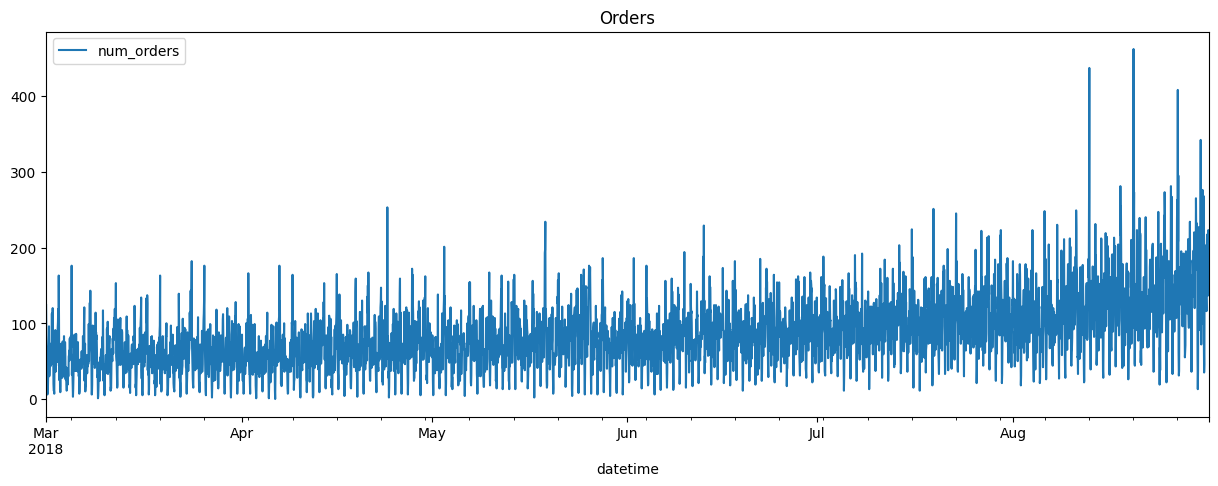

In [6]:
plt.figure(figsize=(15, 5))

data = data.resample('1H').sum()
data.plot(ax=plt.gca())
plt.title('Orders')
plt.show()

It can be noted that the number of orders increases over time. 

Let's verify the data after resampling.

In [7]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


The resampled data has an interval of one hour.

We will use the seasonal_decompose() function to decompose the time series into three components: trend, seasonality, and residue.

In [8]:
decomposed = seasonal_decompose(data)

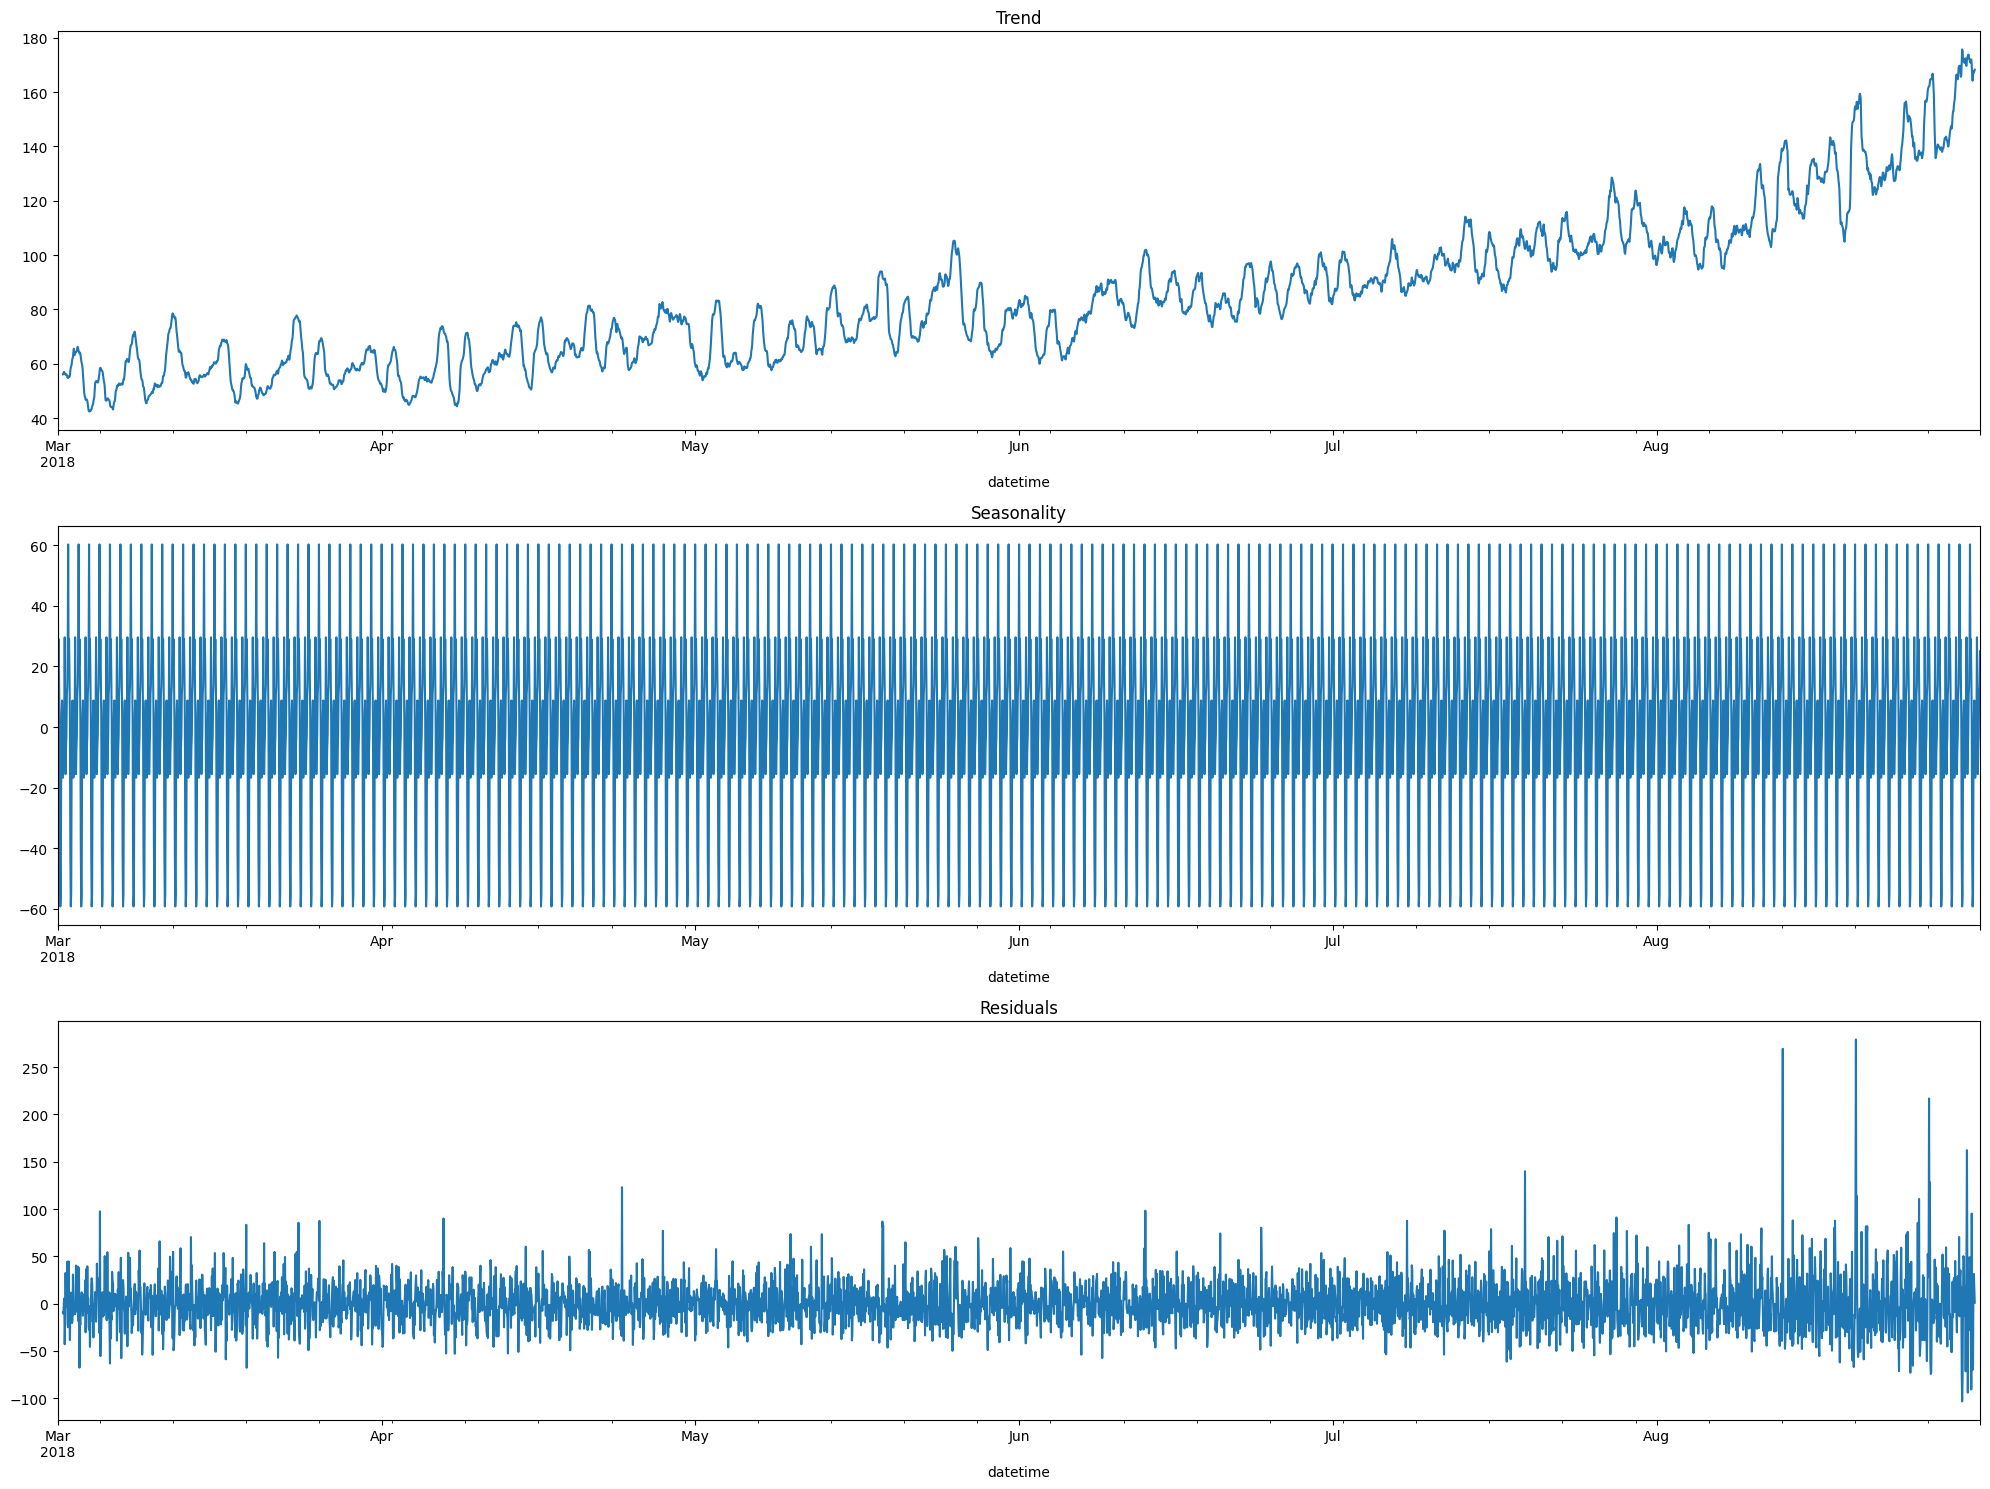

In [ ]:
plt.figure(figsize=(20, 15))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

The increasing trend in the graph indicates an increase in the number of orders over time. The seasonality graph does not show clear patterns. Therefore, let's also plot the seasonal components for a month, a week, and a day.

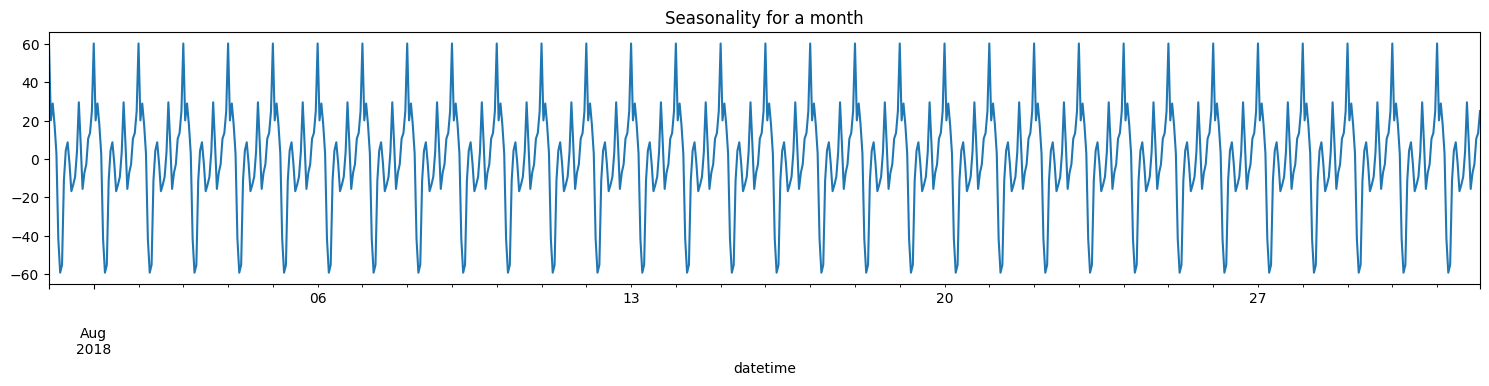

In [10]:
plt.figure(figsize=(15, 10))

plt.subplot(312)
decomposed.seasonal['2018-07-31':'2018-08-31'].plot(ax=plt.gca())
plt.title('Seasonality for a month')
plt.tight_layout()

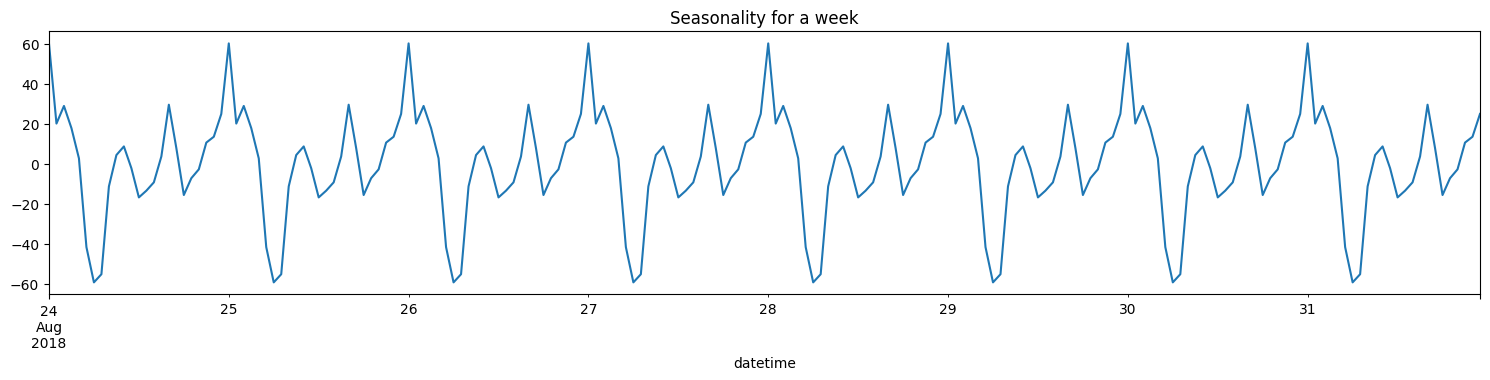

In [11]:
plt.figure(figsize=(15, 10))

plt.subplot(312)
decomposed.seasonal['2018-08-24':'2018-08-31'].plot(ax=plt.gca())
plt.title('Seasonality for a week')
plt.tight_layout()

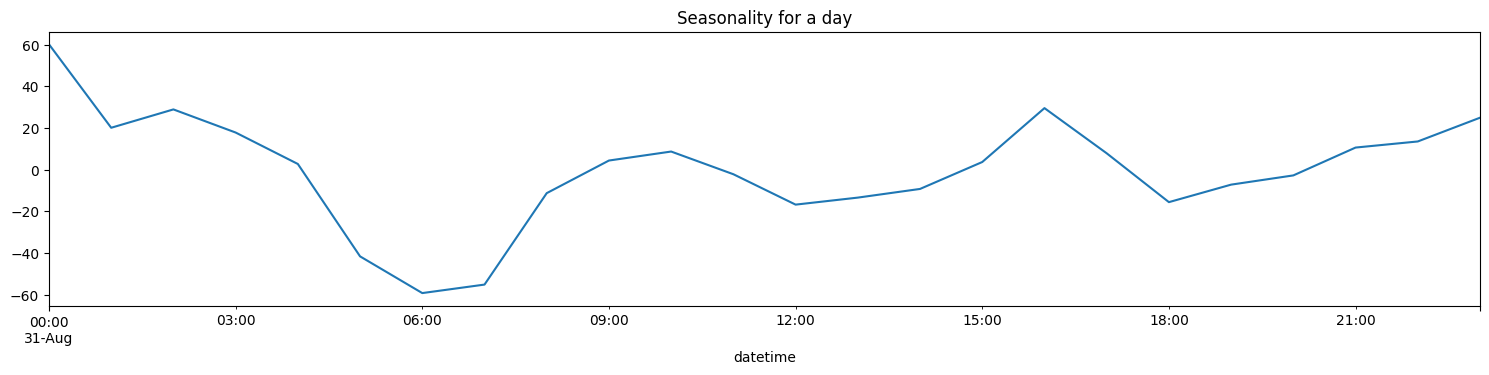

In [12]:
plt.figure(figsize=(15, 10))

plt.subplot(312)
decomposed.seasonal['2018-08-31 00:00:00':'2018-08-31 23:50:00'].plot(ax=plt.gca())
plt.title('Seasonality for a day')
plt.tight_layout()

Seasonality in orders is evident only during the day, with a peak at 00:00, followed by a gradual decrease in the number of orders until 06:00. Order growth is observed in intervals from 06:00 to 10:00, from 12:00 to 16:00, and from 18:00 to 00:00.

In the next step we will add three new calendar features (month, day, and day of the week) to the table using the make_features() function, calculate lag values and compute the rolling mean.

In [13]:
# Defining the make_features() function 

def make_features(data, max_lag, rolling_mean_size):
    
    # Adding two new calendar features to the table
    
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    # Calculating lag values
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    # Calculating the rolling mean and adding it as a feature 'rolling_mean'
    
    data['rolling_mean']  = data['num_orders'].shift().rolling(rolling_mean_size).mean()

# Applying the function to the table
    
make_features(data, 48, 24)

# Printing the first five rows of the function output 

display(data.head())

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_40,lag_41,lag_42,lag_43,lag_44,lag_45,lag_46,lag_47,lag_48,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,124.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,2,85.0,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,4,66.0,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Now it's time to split the data into training and testing sets.

In [14]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna() 

print(train.shape)
print(test.shape)

(3926, 52)
(442, 52)


Let's check the correctness of the resulting partitions.

In [15]:
print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

2018-03-03 00:00:00 2018-08-13 13:00:00
2018-08-13 14:00:00 2018-08-31 23:00:00


The datasets follow the desired sequence.

Now we are going to extract the features and the target variable in the datasets.

In [16]:
train_features = train.drop('num_orders', axis=1)
test_features = test.drop('num_orders', axis=1)

## Model Training

In the next stage we will train the linear model **LinearRegression** and gradient boosting models **LightGBM**, **CatBoost**, and will choose the best model based on the **RMSE** metric.

### LinearRegression

In [17]:
# Creating a dictionary of model parameters for GridSearchCV

param_linear = {"fit_intercept": [True, False]}

In [18]:
# Creating the LinearRegression model

model_linear = LinearRegression()

# Using GridSearchCV to find the best parameters

grid_linear = GridSearchCV(model_linear, param_linear, cv=TimeSeriesSplit(), scoring="neg_root_mean_squared_error")
grid_linear.fit(train_features, train['num_orders'])

# Saving the best model

linear_best = grid_linear.best_estimator_

# Displaying the best model

print("Best model:", linear_best)

# Calculating the RMSE

rmse_linear = mean_squared_error(train['num_orders'], linear_best.predict(train_features), squared=False)

print("RMSE for the LinearRegression model:", rmse_linear)

Best model: LinearRegression(fit_intercept=False)
RMSE for the LinearRegression model: 23.454496063966772


### LightGBM

In [19]:
# Creating a dictionary of model parameters for GridSearchCV

params = {
    "learning_rate": [0.05, 0.1, 0.2],
    "n_estimators": [50, 70, 100]
}

In [20]:
# Creating the LightGBM model

model_lgb = lgb.LGBMRegressor(random_state=RANDOM_STATE)

# Using GridSearchCV to find the best parameters

grid = GridSearchCV(model_lgb, param_grid=params, cv=TimeSeriesSplit(), scoring="neg_root_mean_squared_error")
grid.fit(train_features, train['num_orders'])

# Saving the best model

lgb_best = grid.best_estimator_

# Displaying the best model

print("Best model:", lgb_best)

# Calculating the RMSE

rmse = mean_squared_error(train['num_orders'], lgb_best.predict(train_features), squared=False)

# Displaying the results

print("RMSE for the LGBMRegressor model:", rmse)

Best model: LGBMRegressor(n_estimators=70, random_state=12345)
RMSE for the LGBMRegressor model: 12.937825638004258


### CatBoostRegressor

In [21]:
# Creating a dictionary of model parameters for GridSearchCV

param_grid = {
    "depth": [6, 8, 10],
    "iterations": [50, 100, 150]
}

In [22]:
# Creating the CatBoostRegressor model

model_catb = CatBoostRegressor(random_state=RANDOM_STATE)

# Using GridSearchCV to find the best parameters

grid_search_catb = GridSearchCV(model_catb, param_grid, cv=TimeSeriesSplit(), scoring="neg_root_mean_squared_error", \
                               verbose=1)
grid_search_catb.fit(train_features, train['num_orders'])

# Saving the best model

catb_best = grid_search_catb.best_estimator_

# Displaying the best model

print("Best model:", catb_best)

# Calculating the RMSE

rmse_catb = mean_squared_error(train['num_orders'], catb_best.predict(train_features), squared=False)

# Displaying the results

print("RMSE for the CatBoostRegressor model:", rmse_catb)

Best model: <catboost.core.CatBoostRegressor object at 0x15f6692d0>
RMSE for the CatBoostRegressor model: 8.045513258492555


To evaluate the quality of the models, the obtained results are compiled into one table.

In [23]:
# Passing the metric values to the DataFrame constructor()

results = pd.DataFrame(
    {'Prediction Quality (RMSE)' : [rmse_linear, rmse, rmse_catb]
    })

# Assigning names to the indexes

results.index = ['LinearRegression', 'LightGBM', 'CatBoost']

# Displaying the table

display(results)

,Prediction Quality (RMSE)
LinearRegression,23.454496
LightGBM,12.937826
CatBoost,8.045513


**`The CatBoostRegressor`** model showed the **best result** with the lowest RMSE value (8.04).

## Testing

Let's check the data on the test set.

In [24]:
# To obtain predictions for the test data, call the predict method

model_prediction_test = catb_best.predict(test_features)
rmse_catb_test = mean_squared_error(test['num_orders'], model_prediction_test, squared=False)
print("RMSE for CatBoostRegressor on the test set:", rmse_catb_test)

RMSE for CatBoostRegressor on the test set: 43.83269556032816


Next we will examine how the model performs with predictions by visualizing the distribution of actual and forecasted values.

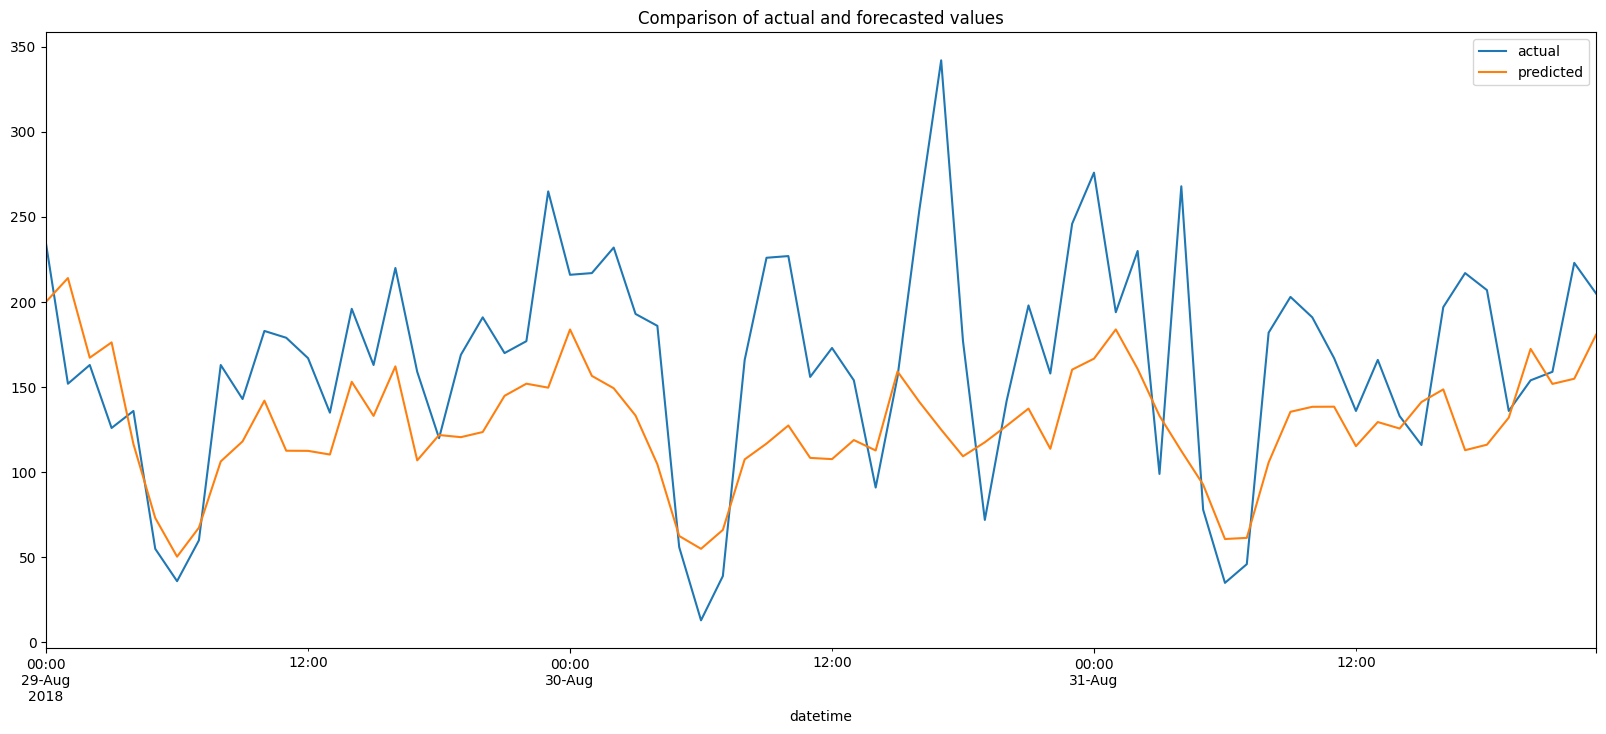

In [25]:
comparison = pd.DataFrame({ 'actual': test['num_orders'], \
                           'predicted': model_prediction_test})['2018-08-29':'2018-08-31']
comparison.plot(figsize=(20, 8), title='Comparison of actual and forecasted values');

Overall, the model captures the trend but tends to average the results. To improve the model's performance in such situations, coefficient systems can be considered for results deviating from the average over the previous 24 hours.

Thus, the RMSE metric value on the test set is 43.83 (satisfying the condition of not exceeding 48).

## Conclusion

During the research the following work has been conducted.

✔️ Data has been examined.

✔️ Data has been resampled.

✔️ Trend and seasonality have been analyzed.

✔️ Features have been created, and datasets have been prepared for model training.

✔️ Three models have been trained: LinearRegression, LightGBM, and CatBoost.

✔️ Model quality has been analyzed:
* The LinearRegression model's quality is 23.45.
* The LightGBM model's quality is 12.94.
* The CatBoost model's quality is 8.04.

Based on the obtained results, the **best model** for predicting the number of taxi orders for the next hour is **CatBoost**.

✔️ Data has been tested on the test set.

✔️ The RMSE metric value on the test set is 43.83 (satisfying the condition of not exceeding 48).